In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy

In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


`01_nh_ghmatch.pickle`: No need  
`02_MWA1s.pickle`: No need  
`03_MWA1s.pickle`: No need  
`06_nh_subhalo_pairs.pickle`: No need  
`08_nh_scores.pickle`: Already used  
`08_nh_dm_scores.pickle`: Already used  
`09_value_added.pickle`: Already used  
`10_real_members.pickle`: No need  
`11_LocalGroup.pickle`: No need  
`14_mass_in_sub.pickle`: RECALCULATE  
`16_LocalGroup.pickle`: No need  

In [3]:
LG = pklload("./database/00_LocalGroup_fix.pickle")
print(LG.keys())
print(LG[2].keys())

dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207, 11])
dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real'])


# All raw data are included?

In [4]:
for key in tqdm(LG.keys()):
    BGG = LG[key]['BGG']
    buffer = BGG['r200_code']/10
    x1,x2 = BGG['x']-BGG['r200_code'], BGG['x']+BGG['r200_code']
    y1,y2 = BGG['y']-BGG['r200_code'], BGG['y']+BGG['r200_code']
    z1,z2 = BGG['z']-BGG['r200_code'], BGG['z']+BGG['r200_code']
    sats = LG[key]['sats']
    if(len(sats)>0):
        x1 = min(x1, (sats['x']-sats['r']).min())
        x2 = max(x2, (sats['x']+sats['r']).max())
        y1 = min(y1, (sats['y']-sats['r']).min())
        y2 = max(y2, (sats['y']+sats['r']).max())
        z1 = min(z1, (sats['z']-sats['r']).min())
        z2 = max(z2, (sats['z']+sats['r']).max())
    subs = LG[key]['subs']
    if(len(subs)>0):
        x1 = min(x1, (subs['x']-subs['r']).min())
        x2 = max(x2, (subs['x']+subs['r']).max())
        y1 = min(y1, (subs['y']-subs['r']).min())
        y2 = max(y2, (subs['y']+subs['r']).max())
        z1 = min(z1, (subs['z']-subs['r']).min())
        z2 = max(z2, (subs['z']+subs['r']).max())
    ibox = np.array([[x1,x2],[y1,y2],[z1,z2]])
    
    idm = pklload(f"./database/parts/nh_dm_{key:04d}.pickle")
    resave = False
    if( idm['x'].min() > x1 ): resave = True     
    if( idm['x'].max() < x2 ): resave = True
    if( idm['y'].min() > y1 ): resave = True
    if( idm['y'].max() < y2 ): resave = True
    if( idm['z'].min() > z1 ): resave = True
    if( idm['z'].max() < z2 ): resave = True
    if(resave):
        print(f"[{key:04d}] Resave!")
        print(f"\t{ibox} ->")
        ibox[0,0] = min(ibox[0,0], idm['x'].min()) - buffer
        ibox[0,1] = max(ibox[0,1], idm['x'].max()) + buffer
        ibox[1,0] = min(ibox[1,0], idm['y'].min()) - buffer
        ibox[1,1] = max(ibox[1,1], idm['y'].max()) + buffer
        ibox[2,0] = min(ibox[2,0], idm['z'].min()) - buffer
        ibox[2,1] = max(ibox[2,1], idm['z'].max()) + buffer
        print(f"\t{ibox}")
        snap.box = ibox
        snap.get_part(nthread=36)
        pklsave(snap.part['star'].table, f"./database/parts/nh_star_{BGG['id']:04d}.pickle", overwrite=True)
        pklsave(snap.part['dm'].table, f"./database/parts/nh_dm_{BGG['id']:04d}.pickle", overwrite=True)
        snap.get_cell(nthread=36)
        pklsave(snap.cell.table, f"./database/parts/nh_cell_{BGG['id']:04d}.pickle", overwrite=True)
        snap.clear()

100%|██████████| 33/33 [00:17<00:00,  1.92it/s]


# Mass in Subhalos

See `01_needed_data.py`  
Output:
- `./database/photo/01_compare_pairs/NH_{key:04d}_mratio.png`
- `./database/01_mass_in_sub.pickle`

# Calculate All subhalos

In [5]:
mass_in_sub = pklload("./database/01_mass_in_sub.pickle")
mass_in_sub_rvir = pklload("./database/01_mass_in_sub_rvir.pickle")

In [6]:
mass_in_sub.dtype

dtype((numpy.record, [('host', '<i4'), ('sub', '<i4'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8')]))

  0%|          | 0/2865 [00:00<?, ?it/s]

100%|██████████| 2865/2865 [00:41<00:00, 68.88it/s]


`./database/photo/01_compare_pairs/NH_all_mratio.png` save done


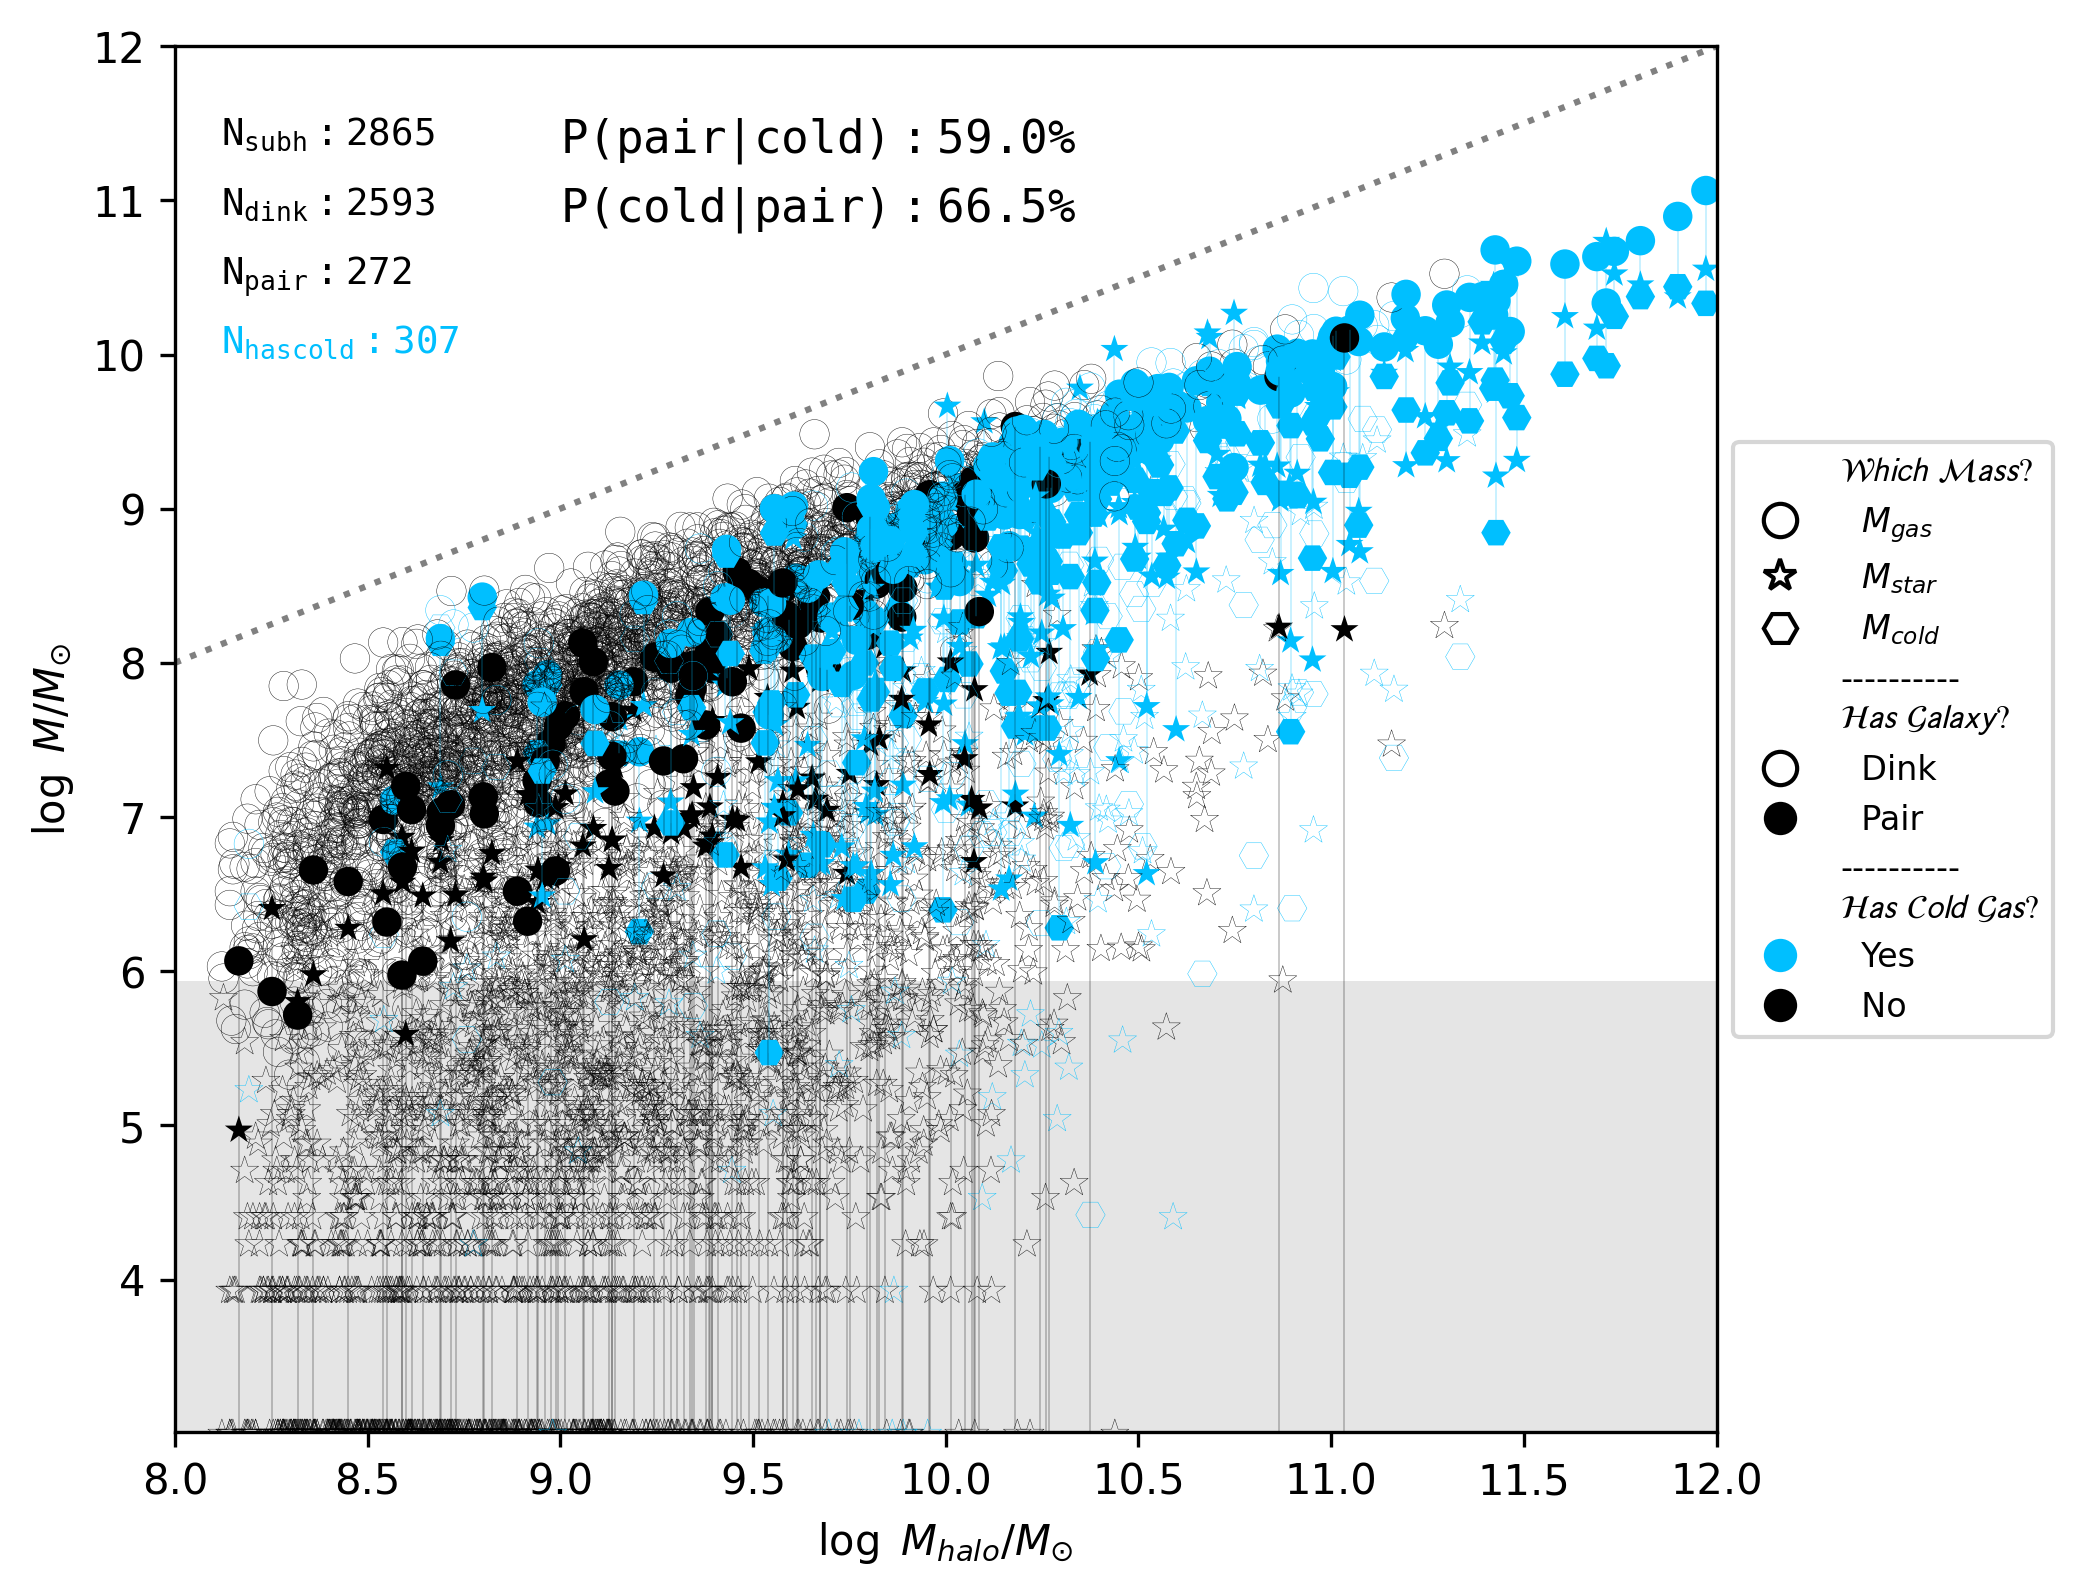

In [7]:
fig, ax = plt.subplots(dpi=300, figsize=(8,6))
for iarr in tqdm(mass_in_sub):
    isdink = iarr['dink']
    color = 'k' if(iarr['mcold']<=1e3) else 'deepskyblue'
    facecolor='none' if(isdink) else color
    edgecolor=color if(isdink) else 'none'
    linecolor=color
    lw = 0.1 if(isdink) else 0.3

    ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mstar']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1, marker='*')
    if(iarr['mcold']>1e3): ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mcold']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1, marker='H')
    ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mcell']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1)
    if(not isdink):
        vmax = np.max([np.log10(iarr['mstar']), np.log10(iarr['mcell']), np.log10(iarr['mcold'])])
        vmin = np.min([np.log10(iarr['mstar']), np.log10(iarr['mcell']), np.log10(iarr['mcold'])])
        ax.plot([np.log10(iarr['mdm']),np.log10(iarr['mdm'])], [vmin, vmax], color=linecolor, lw=0.1)

ax.fill_between([7.9,12.1],3, np.log10(np.min(gals['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

ax.set_xlim(8,12)
xlim = ax.get_xlim()
ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
ax.set_ylim(3.01,12)
ax.set_xlabel(r"$\log\ M_{halo}/M_{\odot}$")
ax.set_ylabel(r"$\log\ M/M_{\odot}$")

hascold = mass_in_sub['mcold'] > 1e3
haspair = ~mass_in_sub['dink']
dinks = mass_in_sub[mass_in_sub['dink']]
pairs = mass_in_sub[~mass_in_sub['dink']]
ax.text(0.03, 0.95, fr"$\mathtt{{ N_{{subh}}: {len(mass_in_sub)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.90, fr"$\mathtt{{ N_{{dink}}: {len(dinks)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.85, fr"$\mathtt{{ N_{{pair}}: {len(pairs)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.80, fr"$\mathtt{{ N_{{has cold}}: {np.sum(hascold)} }}$", ha='left', va='top', color='deepskyblue', fontsize=9, transform=ax.transAxes)
ax.text(0.25, 0.95, fr"$\mathtt{{ P(pair|cold): {100*np.sum(haspair&hascold)/np.sum(hascold):.1f}\% }}$", ha='left', va='top', color='k', fontsize=11, transform=ax.transAxes)
ax.text(0.25, 0.90, fr"$\mathtt{{ P(cold|pair): {100*np.sum(haspair&hascold)/np.sum(haspair):.1f}\% }}$", ha='left', va='top', color='k', fontsize=11, transform=ax.transAxes)

# Making Legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
    Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
    Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label="----------\n"+r'$\mathcal{Has\ Galaxy?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label='  Dink'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='k', markersize=8, label='  Pair'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label="----------\n"+r'$\mathcal{Has\ Cold\ Gas?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='deepskyblue', markersize=8, label='  Yes'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='k', markersize=8, label='  No'),
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
ax.set_aspect(1/2.5)
fig.savefig(f"./database/photo/01_compare_pairs/NH_all_mratio.png", dpi=400, facecolor='white', bbox_inches='tight')
print(f"`./database/photo/01_compare_pairs/NH_all_mratio.png` save done")
plt.show()
plt.close()

  7%|▋         | 204/2865 [00:00<00:11, 225.23it/s]

100%|██████████| 2865/2865 [00:41<00:00, 68.30it/s]


`./database/photo/01_compare_pairs/NH_all_mratio_rvir.png` save done


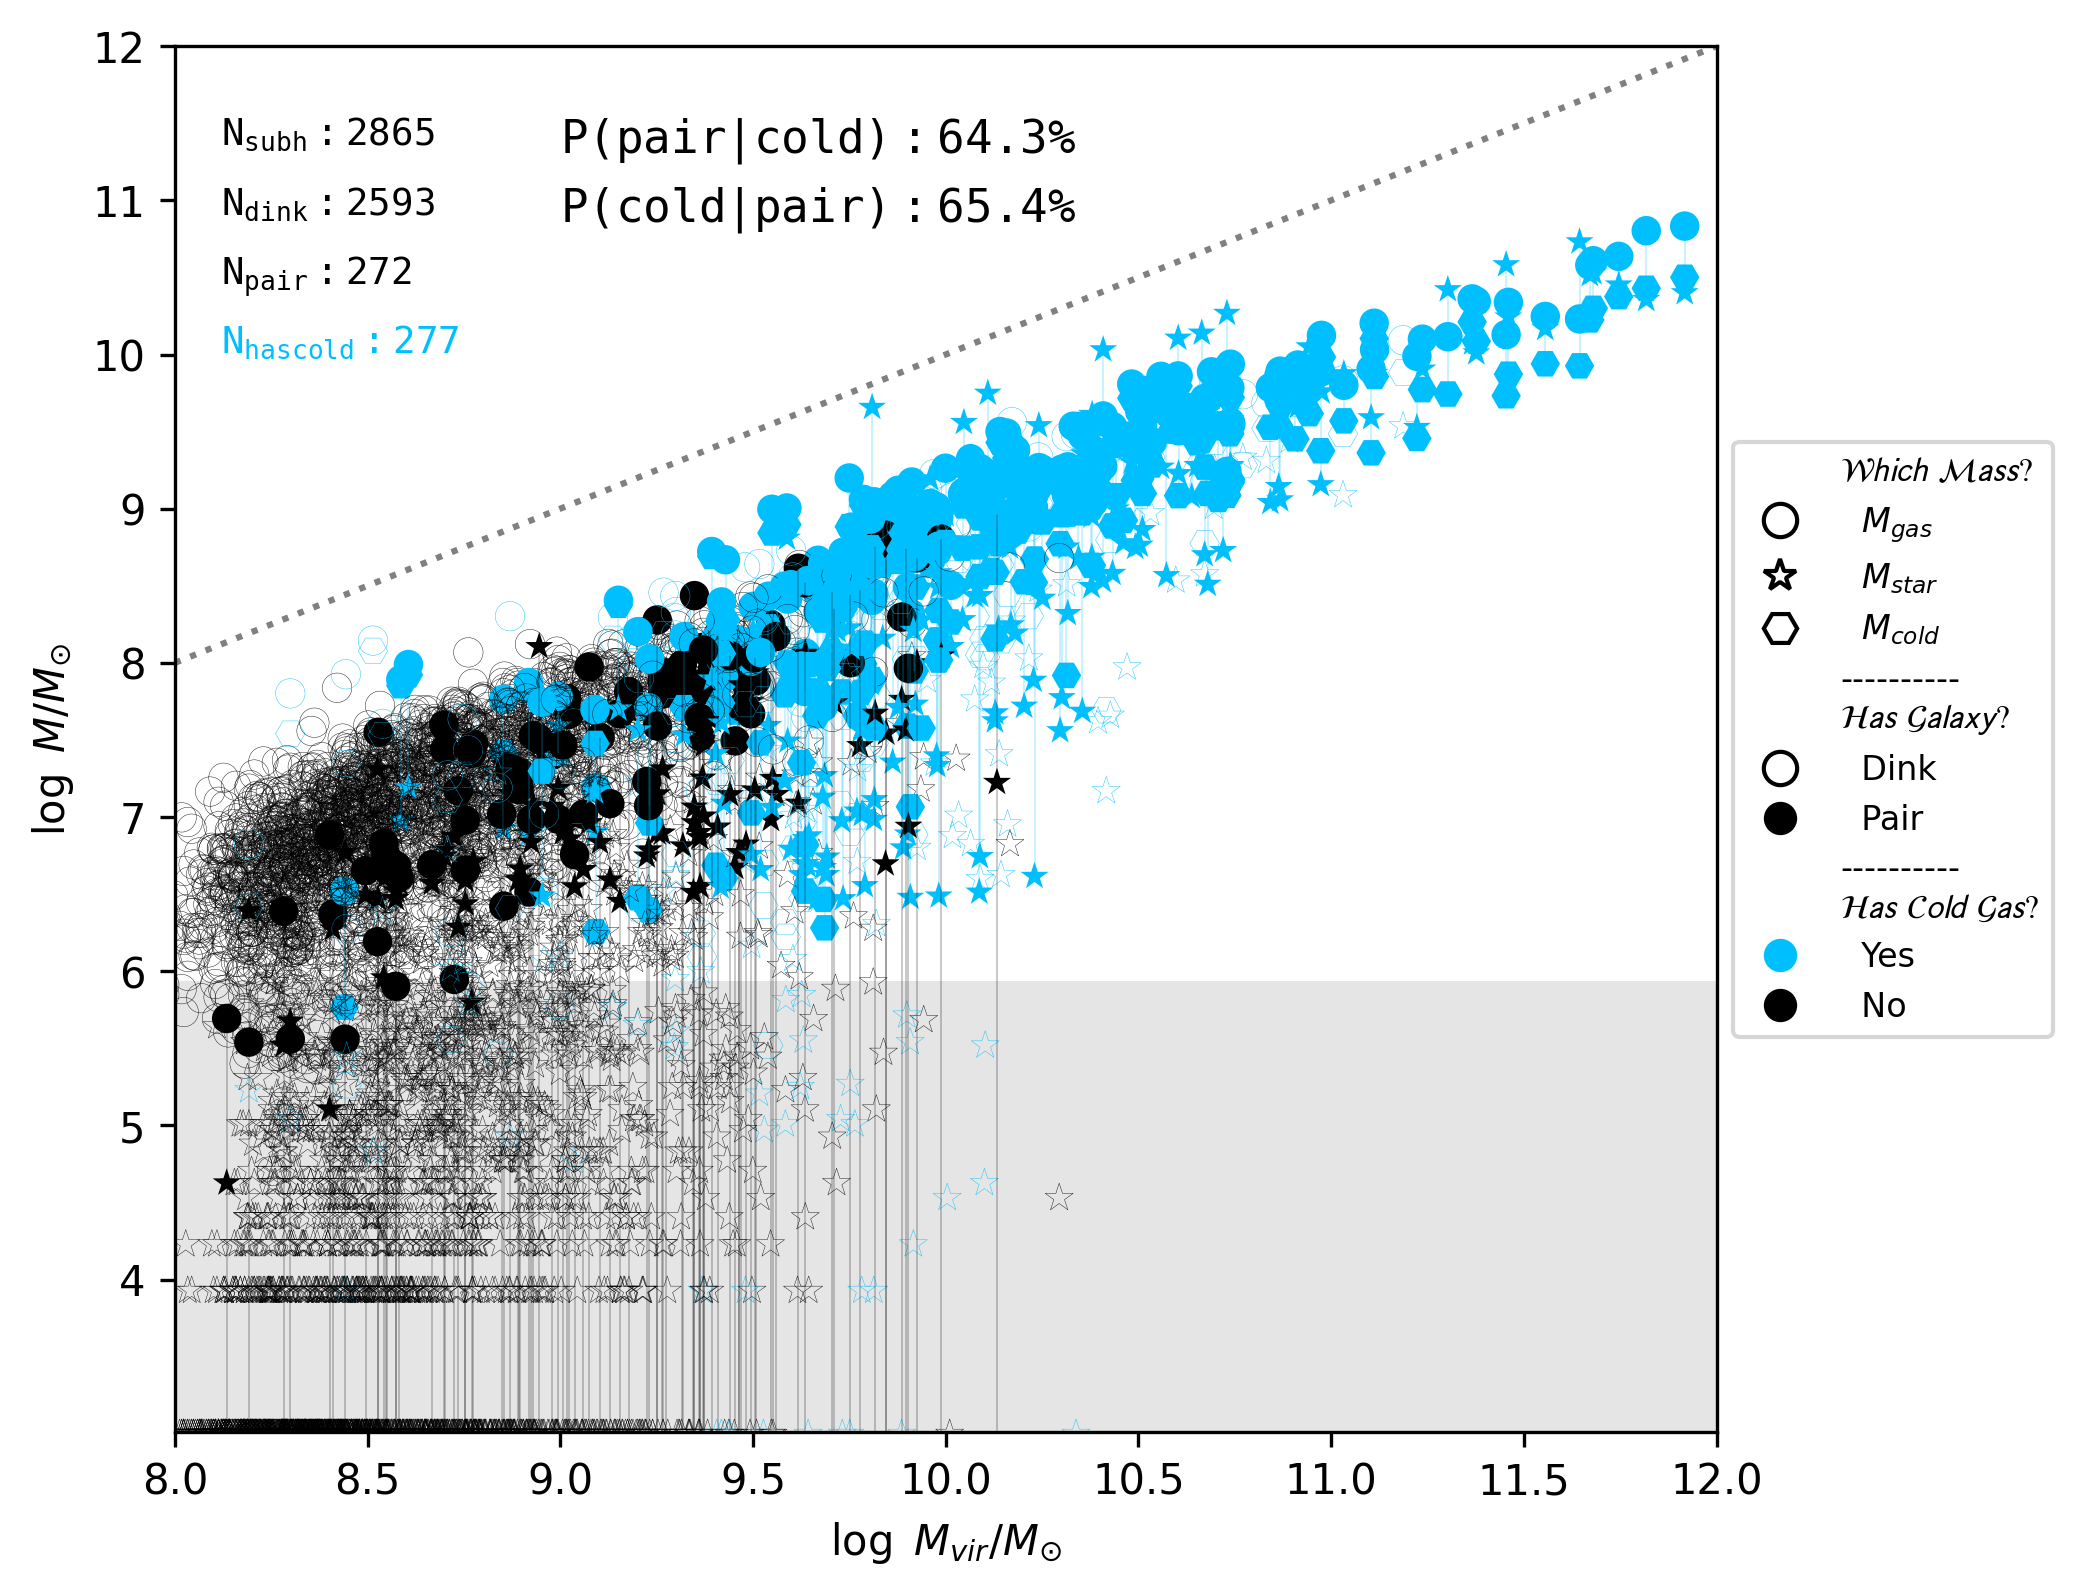

In [8]:
fig, ax = plt.subplots(dpi=300, figsize=(8,6))
for iarr in tqdm(mass_in_sub_rvir):
    isdink = iarr['dink']
    color = 'k' if(iarr['mcold']<=1e3) else 'deepskyblue'
    facecolor='none' if(isdink) else color
    edgecolor=color if(isdink) else 'none'
    linecolor=color
    lw = 0.1 if(isdink) else 0.3

    ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mstar']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1, marker='*')
    if(iarr['mcold']>1e3): ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mcold']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1, marker='H')
    ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mcell']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1)
    if(not isdink):
        vmax = np.max([np.log10(iarr['mstar']), np.log10(iarr['mcell']), np.log10(iarr['mcold'])])
        vmin = np.min([np.log10(iarr['mstar']), np.log10(iarr['mcell']), np.log10(iarr['mcold'])])
        ax.plot([np.log10(iarr['mdm']),np.log10(iarr['mdm'])], [vmin, vmax], color=linecolor, lw=0.1)

ax.fill_between([7.9,12.1],3, np.log10(np.min(gals['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

ax.set_xlim(8,12)
xlim = ax.get_xlim()
ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
ax.set_ylim(3.01,12)
ax.set_xlabel(r"$\log\ M_{vir}/M_{\odot}$")
ax.set_ylabel(r"$\log\ M/M_{\odot}$")

hascold = mass_in_sub_rvir['mcold'] > 1e3
haspair = ~mass_in_sub_rvir['dink']
dinks = mass_in_sub_rvir[mass_in_sub_rvir['dink']]
pairs = mass_in_sub_rvir[~mass_in_sub_rvir['dink']]
ax.text(0.03, 0.95, fr"$\mathtt{{ N_{{subh}}: {len(mass_in_sub_rvir)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.90, fr"$\mathtt{{ N_{{dink}}: {len(dinks)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.85, fr"$\mathtt{{ N_{{pair}}: {len(pairs)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.80, fr"$\mathtt{{ N_{{has cold}}: {np.sum(hascold)} }}$", ha='left', va='top', color='deepskyblue', fontsize=9, transform=ax.transAxes)
ax.text(0.25, 0.95, fr"$\mathtt{{ P(pair|cold): {100*np.sum(haspair&hascold)/np.sum(hascold):.1f}\% }}$", ha='left', va='top', color='k', fontsize=11, transform=ax.transAxes)
ax.text(0.25, 0.90, fr"$\mathtt{{ P(cold|pair): {100*np.sum(haspair&hascold)/np.sum(haspair):.1f}\% }}$", ha='left', va='top', color='k', fontsize=11, transform=ax.transAxes)

# Making Legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
    Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
    Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label="----------\n"+r'$\mathcal{Has\ Galaxy?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label='  Dink'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='k', markersize=8, label='  Pair'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label="----------\n"+r'$\mathcal{Has\ Cold\ Gas?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='deepskyblue', markersize=8, label='  Yes'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='k', markersize=8, label='  No'),
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
ax.set_aspect(1/2.5)
fig.savefig(f"./database/photo/01_compare_pairs/NH_all_mratio_rvir.png", dpi=400, facecolor='white', bbox_inches='tight')
print(f"`./database/photo/01_compare_pairs/NH_all_mratio_rvir.png` save done")
plt.show()
plt.close()